(c) [Julius Hense](https://github.com/hense96) & [Mina Jamshidi](https://github.com/minajamshidi) @ TU Berlin, 2024

(c) This notebook is an asset of xMIL: https://github.com/tubml-pathology/xMIL

Please note the license and citation instructions as described in the above repository.

---

# Pipeline for computing heatmaps and visualizing them

In this notebook, we demonstrate how to compute the explanation scores of a given slide and visualize the heatmap. At the end of the pipeline, you can generate overlay of the heatmap for potential use in softwares like QuPath.

Please note that in this notebook we explain the target class. please modify the respective parts (with corresponding comments in the code) in case you wanna change the explained class. 

If you have already computed and saved the explanation scores using ```test.py```, you can use the notebook ```slide_visualizations_precomputed_heatmaps```. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import os
import json
import ast

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import openslide
import PIL

from training.callback import Callback
from models.model_factory import ModelFactory, xModelFactory
from datasets.dataset_factory import DatasetFactory

from visualization.slideshow import slide_heatmap_thumbnail, heatmap_PIL, plot_PIL
from visualization.utils import clean_outliers_fliers

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 1. Select and load a model of interest

In [5]:
# === SPECIFY === #

model_name = 'transmil'
proj_name = 'hnsc_hpv'

model_dir_root = '/path/to/results/trained_models'  # *** SPECIFY ======

model_dir = os.path.join(model_dir_root, proj_name, model_name)  # or specify your model directory directly here 


In [6]:
with open(os.path.join(model_dir, 'args.json')) as f:
    args = json.load(f)

slides_dirs = [patches_dir[:-11] + 'slides' for patches_dir in args['patches_dirs']]
annotation_dirs = [patches_dir[:-11] + 'annotations' for patches_dir in args['patches_dirs']
                   if os.path.isdir(patches_dir[:-11] + 'annotations')]
patches_dirs = args['patches_dirs']

print(slides_dirs)
print(annotation_dirs)
print(patches_dirs)

['/home/space/datasets/tcga/hnsc/slides']
[]
['/home/space/datasets/tcga/hnsc/patches/20x']


In [7]:
args

{'split_path': '/home/space/datasets/tcga/splits/tcga_hnsc_hpv_cv3_0.csv',
 'metadata_dirs': ['/home/space/datasets/tcga/hnsc/metadata/v001'],
 'patches_dirs': ['/home/space/datasets/tcga/hnsc/patches/20x'],
 'features_dirs': ['/home/space/datasets/tcga/hnsc/features/20x/ctranspath_pt'],
 'results_dir': '/home/juliush/results/xMIL/models/hopt_v3b/hnsc_hpv/transmil/fold_0/1',
 'model_param_path': None,
 'train_subsets': ['1', '2'],
 'val_subsets': ['0'],
 'test_subsets': ['0'],
 'balance_key': None,
 'sampler': None,
 'drop_duplicates': 'sample',
 'patch_filters': None,
 'train_bag_size': 2048,
 'max_bag_size': 24000,
 'preload_data': True,
 'aggregation_model': 'transmil',
 'input_dim': 768,
 'num_classes': 2,
 'targets': ['label'],
 'no_bias': False,
 'additive': False,
 'n_out_layers': 0,
 'features_dim': 256,
 'inner_attention_dim': 128,
 'dropout_strategy': 'features',
 'dropout': 0,
 'num_layers': 1,
 'num_features': 256,
 'dropout_att': 0.0,
 'dropout_class': 0.0,
 'dropout_feat'

In [8]:
# define callback, model, classifier, xmodel
sel_checkpoint = 'best'

callback = Callback(
        schedule_lr=args['schedule_lr'], checkpoint_epoch=1, path_checkpoints=model_dir,
        early_stop=args['early_stopping'], device=device)
model, classifier = ModelFactory.build(args, device)
model = callback.load_checkpoint(model, checkpoint=sel_checkpoint)

In [9]:
xmodel_args = {'explained_class': None} # change this if you wish to explain a specific class
xmodel = xModelFactory.build(model, xmodel_args)

## 2. Visualizing explanation heatmaps

### 2.1. Read the pre-computed explanation scores of a desired slide

In [11]:
# load the data_loader of interest based on the user argument args_user.dataset
dataset = 'test'

none_datasets = [f'{set_name}_subsets' for set_name in ['train', 'val', 'test'] if set_name != dataset]
for set_name in none_datasets:
    args[set_name] = None
    
_, train_loader, _, val_loader, _, test_loader = DatasetFactory.build(args, args)

data_loader = [loader for loader in [train_loader, val_loader, test_loader] if loader is not None][0]


Loading dataset for subsets: ['0']
Loading patch metadata


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145/145 [00:03<00:00, 39.10it/s]


Dropping 2 slides with more than 24000 patches.
Loading features into RAM


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:08<00:00, 16.09it/s]


In [12]:
data_loader_list = list(data_loader)

In [13]:
# ==== find the index of the batch a desired slide if the data loader object ==== 
slide_name = 'TCGA-BA-5559-01Z-00-DX1' # *** SPECIFY: the ID of the desired slide
sel_idx = [i for i, batch in enumerate(data_loader_list) if batch['slide_id'][0] == slide_name][0]

# === or if you know the index of the batch ==== 
# sel_idx = 7  # *** SPECIFY: the desired batch index in the data_loader

print(f'selected index: {sel_idx}')

batch = data_loader_list[sel_idx]

batch

selected index: 7


{'features': tensor([[[ 0.0785,  0.0975,  0.0225,  ...,  0.0935,  0.0422,  0.0717],
          [ 0.1330,  0.1186, -0.0297,  ...,  0.0577, -0.0758,  0.0838],
          [ 0.0942,  0.0263, -0.0169,  ...,  0.1418, -0.0554,  0.0214],
          ...,
          [ 0.0498,  0.0013, -0.0052,  ...,  0.0961, -0.0483, -0.0189],
          [ 0.0637,  0.0283,  0.0812,  ...,  0.1978, -0.0361,  0.0067],
          [ 0.0566,  0.0961,  0.0246,  ...,  0.1881, -0.0255, -0.0019]]]),
 'bag_size': tensor([5969]),
 'targets': tensor([[1]]),
 'patch_ids': tensor([[   40,    41,    42,  ..., 35835, 35839, 35840]]),
 'source_id': tensor([0]),
 'slide_id': ['TCGA-BA-5559-01Z-00-DX1']}

In [14]:
# compute prediction information

preds, label, _, slide_info = classifier.validation_step(batch)

label = label.item()
source_idx = slide_info['source_id'][0]
slide_name = slide_info['slide_id'][0]

exlained_class = label # we want to explain the target class, change this if you wish to change it
pred_score = preds[0, exlained_class].item()  

print(slide_name, label, pred_score)

TCGA-BA-5559-01Z-00-DX1 1 0.9214591979980469


### 2.2. Plotting the heatmap

#### Visualize the slide and its annotation

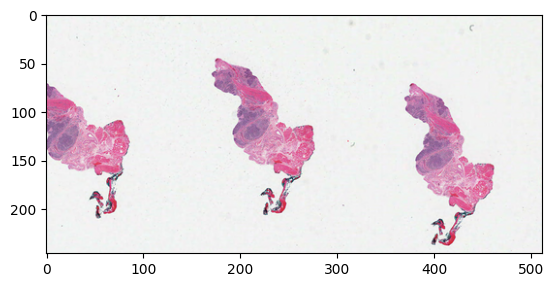

In [15]:
# Read slide, annotation, patch metadata
slide_extension = 'svs'

slide = openslide.open_slide(os.path.join(slides_dirs[source_idx], f'{slide_name}.{slide_extension}'))

if len(annotation_dirs) > 0:
    annotation = openslide.open_slide(os.path.join(annotation_dirs[source_idx], f"{slide_name}.png"))
else:
    annotation = None
    
patches_this_slide = pd.read_csv(os.path.join(patches_dirs[source_idx], slide_name, 'metadata/df.csv'), index_col=0)
slide_thumbnail = slide.get_thumbnail((512, 512))
if annotation is None:
    plt.imshow(slide_thumbnail)
else:
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    axs[0].imshow(slide_thumbnail)
    axs[1].imshow(annotation.get_thumbnail((512, 512)))


#### Compute and visualize the heatmap of the desired explanation method

In [16]:
# =========== SPECIFY =============
sel_explanation = 'lrp'  # ***SPECIFY: could be perturbation_keep, lrp, gi, grad2

if sel_explanation == 'perturbation_keep':
    xmodel.explained_rel = 'softmax'
else:
    xmodel.explained_rel = 'logit'

In [17]:
# compute explanation scores

patch_ids = batch['patch_ids'].numpy()
patch_ids = patch_ids[0] if len(patch_ids.shape) > 1 else patch_ids

patch_scores = xmodel.get_heatmap(batch, sel_explanation, verbose=False)
patch_scores = patch_scores[0] if len(patch_scores.shape) > 1 else patch_scores

if annotation is not None:
    patch_labels = patches_this_slide.copy().set_index('patch_id').loc[patch_ids]
    patch_labels = patch_labels['annotation_classes'].apply(lambda x: pd.Series(ast.literal_eval(x)))
    patch_labels = np.asarray((patch_labels['2'] > 0.0).astype(int))
else:
    patch_labels = None
    
patch_scores_plot, _ = clean_outliers_fliers(patch_scores)

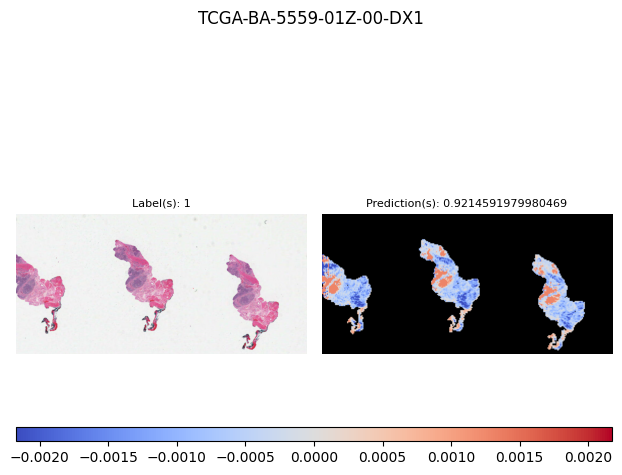

In [18]:
# Visualize patch scores in heatmap
side_by_side = True
show_annotation = True
zero_centered = xmodel.get_heatmap_zero_centered(sel_explanation)

cmap_name = 'coolwarm' if zero_centered else 'Reds'


_ = slide_heatmap_thumbnail(
    slide, patches_this_slide, patch_ids, patch_scores_plot,
    slide_name=slide_name, label=str(label), pred_score=str(pred_score),
    annotation=(annotation if show_annotation else None), side_by_side=side_by_side,
    size=(2048, 2048), cmap_name=cmap_name, background='black', zero_centered=zero_centered)

### 2.3. Generating the overlay for QuPath

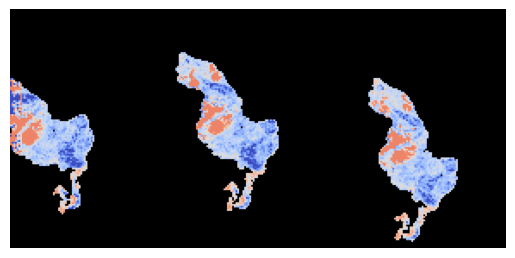

In [19]:
overlay_dims = (slide.dimensions[0] // 32, slide.dimensions[1] // 32)
heatmap, _ = heatmap_PIL(
    patches=patches_this_slide, size=overlay_dims, patch_ids=patch_ids, slide_dim=slide.dimensions, 
    score_values=patch_scores_plot, cmap_name=cmap_name, zero_centered=zero_centered)

fig = plt.figure()
ax = fig.add_subplot(111)

plot_PIL(ax, heatmap, cmap=cmap_name)

# heatmap.save(os.path.join(overlays_dir, f"{slide_name}_{sel_explanation}.png"), "PNG")


------